<div style="text-align: right"> Graph Representation & Analysis - NetworkX
 </div>

# **TUBE TWIN - THE LONDON UNDERGROUND FORECASTING SYSTEM**

<img src="https://www.ft.com/__origami/service/image/v2/images/raw/https%3A%2F%2Fd1e00ek4ebabms.cloudfront.net%2Fproduction%2F2f90cf07-9f8c-4437-ad9b-818989cb2fd2.jpg?dpr=2&fit=scale-down&quality=medium&source=next&width=700" alt="image info" />

## **PROJECT SUMMARY**

The London Underground (aka “The Tube”) is a network of train stations which connects the city. Via an open data API, Transport for London (TfL) publishes data showing in fifteen minute increments the number of people entering and exiting every station. Understanding the behaviour of this transport network presents many similar challenges to the ones we face in understanding water and waste distribution
networks. <br>

### OBJECTIVES
The project should be able to cover the following: <br>
- forecast passenger counts on train lines and stations throughout the year
- effects of special events (eg. football games, holidays, concerts) on the network
- relationship like between passenger counts at different stations
- patterns in usage of the Tube prior and post COVID pandemic, focusing on aggregation, popularity of certain lines, and relationship between counts at different stations
- effects of new lines on existing lines, case in point the Elizabeth Line
-  long-term trends in passenger loads across the different lines and stations
- identification of optimal location where a line can be added
- simulate the network and uncover plausible risks to the network

### GOALS
Expected outputs of the project are: <br>
- A graph representation of the network
- A passenger count forecast at each station (entry and exit), in 15 minutes increments, based on time of day, and counts at other stations
- A study of the effect of significant events (holidays, football games, etc) on traffic
- Dashboard showing key insights to railway technicians and commuters
- Simulation

## **PROJECT DATA FROM TFL API**

Data that will be used in this project is accessed from the TfL API, at https://api-portal.tfl.gov.uk/ <br>

The following data types were identified as potentially being necessary:<br>
- Station data
- Passenger counts
- Air quality
- 

Resources for extraction of the data using the API:<br>
- Request library in python
- Beautiful Soup library in python


## Graph Representation Task

-- NetworkX Library


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# unzipping current version of data available
!unzip /content/drive/MyDrive/Datasets/Tube_Twin_project/Data.zip

Archive:  /content/drive/MyDrive/Datasets/Tube_Twin_project/Data.zip
   creating: Data/londongraphs/
   creating: Data/londongraphs/processed/
  inflating: Data/londongraphs/processed/london.connections.csv  
  inflating: Data/londongraphs/processed/london.lines.csv  
  inflating: Data/londongraphs/processed/london.stations.csv  
   creating: Data/londongraphs/unprocessed/
  inflating: Data/londongraphs/unprocessed/london.connections.csv  
  inflating: Data/londongraphs/unprocessed/london.lines.csv  
  inflating: Data/londongraphs/unprocessed/london.stations.csv  
 extracting: Data/londongraphs/unprocessed/source.txt  
   creating: Data/NUMBAT/
   creating: Data/NUMBAT/FRIDAY/
  inflating: Data/NUMBAT/FRIDAY/2018FRI_Line_Boarders.xlsx  
  inflating: Data/NUMBAT/FRIDAY/2018FRI_Link_Frequency.xlsx  
  inflating: Data/NUMBAT/FRIDAY/2018FRI_Link_Load.xlsx  
  inflating: Data/NUMBAT/FRIDAY/2018FRI_OD_DLR.xlsx  
  inflating: Data/NUMBAT/FRIDAY/2018FRI_OD_EZL.xlsx  
  inflating: Data/NUMBAT/F

In [ ]:
!pip install tflunifiedapi --quiet
!pip install requests --quiet
!pip install geopandas --quiet
!pip install folium --quiet

     |████████████████████████████████| 85 kB 2.7 MB/s 
     |████████████████████████████████| 178 kB 33.4 MB/s 
     |████████████████████████████████| 41 kB 560 kB/s 
     |████████████████████████████████| 1.0 MB 5.4 MB/s 
     |████████████████████████████████| 16.7 MB 55.9 MB/s 
     |████████████████████████████████| 6.3 MB 53.0 MB/s 


In [ ]:
# importing necessary libraries
import numpy as np
import pandas as pd
from tfl.client import Client
from tfl.api_token import ApiToken
import requests
from requests.auth import HTTPBasicAuth
from urllib.parse import urlencode
import logging
import csv

import matplotlib.pyplot as plt
from networkx.drawing.nx_agraph import graphviz_layout
import folium

In [ ]:
# NUMBAT Data - contains Lines Excel file with definitions
numbat_def_excel = "/content/drive/MyDrive/Datasets/Tube_Twin_project/Data_V1/NUMBAT_data_definitions_published.xlsx"

# Graph_Data
lu_stations = pd.read_csv("/content/Data/londongraphs/processed/london.stations.csv")
lu_lines = pd.read_csv("/content/Data/londongraphs/processed/london.lines.csv")
lu_conns = pd.read_csv("/content/Data/londongraphs/processed/london.connections.csv")



In [ ]:
# NUMBAT Definitions Excel file
numbat_definitions_WB = pd.ExcelFile(numbat_def_excel)
# N list all sheets in the file
numbat_definitions_WB.sheet_names



['Version_Control',
 '_Definitions',
 'Modes',
 'Lines',
 'Branches',
 'Links',
 'Nodes',
 'Stations',
 'StationComplexes',
 'DayTypes',
 'Qhr',
 'Timebands',
 'Directions',
 'Movements']

In [ ]:
# getting specific sheets
numbat_stations_xls = pd.read_excel(numbat_definitions_WB, sheet_name="Stations")
numbat_Lines_xls = pd.read_excel(numbat_definitions_WB, sheet_name="Lines")
numbat_Links_xls = pd.read_excel(numbat_definitions_WB, sheet_name="Links")
numbat_defs_xls = pd.read_excel(numbat_definitions_WB, sheet_name='_Definitions')
numbat_Modes_xls = pd.read_excel(numbat_definitions_WB, sheet_name="Modes")
numbat_Branches_xls = pd.read_excel(numbat_definitions_WB, sheet_name="Branches")
numbat_nodes_xls = pd.read_excel(numbat_definitions_WB, sheet_name="Nodes")

In [ ]:
numbat_stations_xls.head()

,MNLC,MASC,StationName,TFL?
0,500,ACTu,Acton Town,True
1,501,BARu,Barbican,True
2,502,ALDu,Aldgate,True
3,503,ALEu,Aldgate East,True
4,504,STId,Stratford International DLR,True


In [ ]:
numbat_Links_xls.shape

(1175, 26)

In [ ]:
numbat_Links_xls.head()

,CodeLong,CodeLong_Simple,CodeShort,LineOrder,Tsys,Line (Name),StartNode,StartNodeCode,StartNodeCode_Simple,StartMNLC,...,EndMNLC,EndMASC,EndStationName,EndNodeName,Line (Code),Dir,Order,Comment,CodeLongBarLine,Line(s) in Model
0,ELEu_BAK_NB>LAMu_BAK_NB@BAK,ELEu_BAK_NB>LAMu_BAK_NB@BAK,ELEu>LAMu@BAK,11,u_BAK,Bakerloo,350410,ELEu_BAK_NB,ELEu_BAK_NB,570,...,628,LAMu,Lambeth North,Bakerloo // NB,BAK,NB,1,NaN,ELEu_BAK_NB>LAMu_BAK_NB,BAK
1,LAMu_BAK_NB>WLOu_BAK_NB@BAK,LAMu_BAK_NB>WLOu_BAK_NB@BAK,LAMu>WLOu@BAK,11,u_BAK,Bakerloo,310310,LAMu_BAK_NB,LAMu_BAK_NB,628,...,747,WLOu,Waterloo LU,Bakerloo // NB,BAK,NB,2,NaN,LAMu_BAK_NB>WLOu_BAK_NB,BAK
2,WLOu_BAK_NB>EMBu_BAK_NB@BAK,WLOu_BAK_NB>EMBu_BAK_NB@BAK,WLOu>EMBu@BAK,11,u_BAK,Bakerloo,310110,WLOu_BAK_NB,WLOu_BAK_NB,747,...,542,EMBu,Embankment,Bakerloo // NB,BAK,NB,3,NaN,WLOu_BAK_NB>EMBu_BAK_NB,BAK
3,EMBu_BAK_NB>CHXu_BAK_NB@BAK,EMBu_BAK_NB>CHXu_BAK_NB@BAK,EMBu>CHXu@BAK,11,u_BAK,Bakerloo,20710,EMBu_BAK_NB,EMBu_BAK_NB,542,...,718,CHXu,Charing Cross LU,Bakerloo // NB,BAK,NB,4,NaN,EMBu_BAK_NB>CHXu_BAK_NB,BAK
4,CHXu_BAK_NB>PICu_BAK_NB@BAK,CHXu_BAK_NB>PICu_BAK_NB@BAK,CHXu>PICu@BAK,11,u_BAK,Bakerloo,20610,CHXu_BAK_NB,CHXu_BAK_NB,718,...,674,PICu,Piccadilly Circus,Bakerloo // NB,BAK,NB,5,NaN,CHXu_BAK_NB>PICu_BAK_NB,BAK


from modes we see London Underground has a mode iD of 10, extracting the lines belonging to LU...


In [ ]:
lines_LU = numbat_Lines_xls.iloc[:10]
lines_LU

,Tsys,OldLineCode,LineCode,LineName,lineNo,modeID
0,u_BAK,BAK,BAK,Bakerloo,11,10
1,u_CEN,CEN,CEN,Central,12,10
2,u_DIS,DIS,DIS,District,13,10
3,u_HAM,HAM,HAM,H&C and Circle,14,10
4,u_JUB,JUB,JUB,Jubilee,15,10
5,u_MET,MET,MET,Metropolitan,16,10
6,u_NOR,NOR,NOR,Northern,17,10
7,u_PIC,PIC,PIC,Piccadilly,18,10
8,u_VIC,VIC,VIC,Victoria,19,10
9,u_WAT,WAT,WAC,Waterloo & City,20,10


In [ ]:
# merging Line with Mode
lines_mode_xls = pd.merge(lines_LU, numbat_Modes_xls, on="modeID", how="inner")
lines_mode_xls

,Tsys,OldLineCode,LineCode,LineName,lineNo,modeID,mode,modecode,modedescription
0,u_BAK,BAK,BAK,Bakerloo,11,10,LU,u,London Underground
1,u_CEN,CEN,CEN,Central,12,10,LU,u,London Underground
2,u_DIS,DIS,DIS,District,13,10,LU,u,London Underground
3,u_HAM,HAM,HAM,H&C and Circle,14,10,LU,u,London Underground
4,u_JUB,JUB,JUB,Jubilee,15,10,LU,u,London Underground
5,u_MET,MET,MET,Metropolitan,16,10,LU,u,London Underground
6,u_NOR,NOR,NOR,Northern,17,10,LU,u,London Underground
7,u_PIC,PIC,PIC,Piccadilly,18,10,LU,u,London Underground
8,u_VIC,VIC,VIC,Victoria,19,10,LU,u,London Underground
9,u_WAT,WAT,WAC,Waterloo & City,20,10,LU,u,London Underground


In [ ]:
# merging lines with links to have only links belonginng to lines in the London Underground
lines_mode_links_xls = pd.merge(lines_mode_xls, numbat_Links_xls, on="Tsys", how="inner")
lines_mode_links_xls

,Tsys,OldLineCode,LineCode,LineName,lineNo,modeID,mode,modecode,modedescription,CodeLong,...,EndMNLC,EndMASC,EndStationName,EndNodeName,Line (Code),Dir,Order,Comment,CodeLongBarLine,Line(s) in Model
0,u_BAK,BAK,BAK,Bakerloo,11,10,LU,u,London Underground,ELEu_BAK_NB>LAMu_BAK_NB@BAK,...,628,LAMu,Lambeth North,Bakerloo // NB,BAK,NB,1,NaN,ELEu_BAK_NB>LAMu_BAK_NB,BAK
1,u_BAK,BAK,BAK,Bakerloo,11,10,LU,u,London Underground,LAMu_BAK_NB>WLOu_BAK_NB@BAK,...,747,WLOu,Waterloo LU,Bakerloo // NB,BAK,NB,2,NaN,LAMu_BAK_NB>WLOu_BAK_NB,BAK
2,u_BAK,BAK,BAK,Bakerloo,11,10,LU,u,London Underground,WLOu_BAK_NB>EMBu_BAK_NB@BAK,...,542,EMBu,Embankment,Bakerloo // NB,BAK,NB,3,NaN,WLOu_BAK_NB>EMBu_BAK_NB,BAK
3,u_BAK,BAK,BAK,Bakerloo,11,10,LU,u,London Underground,EMBu_BAK_NB>CHXu_BAK_NB@BAK,...,718,CHXu,Charing Cross LU,Bakerloo // NB,BAK,NB,4,NaN,EMBu_BAK_NB>CHXu_BAK_NB,BAK
4,u_BAK,BAK,BAK,Bakerloo,11,10,LU,u,London Underground,CHXu_BAK_NB>PICu_BAK_NB@BAK,...,674,PICu,Piccadilly Circus,Bakerloo // NB,BAK,NB,5,NaN,CHXu_BAK_NB>PICu_BAK_NB,BAK
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
715,u_VIC,VIC,VIC,Victoria,19,10,LU,u,London Underground,PIMu_VIC_SB>VUXu_VIC_SB@VIC,...,777,VUXu,Vauxhall LU,Victoria // SB,VIC,SB,13,NaN,PIMu_VIC_SB>VUXu_VIC_SB,VIC
716,u_VIC,VIC,VIC,Victoria,19,10,LU,u,London Underground,VUXu_VIC_SB>STKu_VIC_SB@VIC,...,716,STKu,Stockwell,Victoria // SB,VIC,SB,14,NaN,VUXu_VIC_SB>STKu_VIC_SB,VIC
717,u_VIC,VIC,VIC,Victoria,19,10,LU,u,London Underground,STKu_VIC_SB>BRXu_VIC_SB@VIC,...,778,BRXu,Brixton LU,Victoria // SB,VIC,SB,15,NaN,STKu_VIC_SB>BRXu_VIC_SB,VIC
718,u_WAT,WAT,WAC,Waterloo & City,20,10,LU,u,London Underground,WLOu_WAC_EB>BNKu_WAC_EB@WAC,...,513,BNKu,Bank and Monument,Waterloo & City // EB,WAC,EB,1,NaN,WLOu_WAC_EB>BNKu_WAC_EB,WAT


In [ ]:
lines_mode_links_xls.modedescription.unique

<bound method Series.unique of 0      London Underground
1      London Underground
2      London Underground
3      London Underground
4      London Underground
              ...        
715    London Underground
716    London Underground
717    London Underground
718    London Underground
719    London Underground
Name: modedescription, Length: 720, dtype: object>

In [ ]:
lines_mode_links_xls.to_csv("london_underground_links.csv", index=False)

In [ ]:
numbat_nodes_xls

,NodeNo,NodeCode,NodeCode_Simple,NodeName,MNLC,EntEx,MASC,StationName,NodeName (Platform/Direction)
0,10101.0,BARu_StnEnt1,BARu_StnEnt1,Barbican // EntEx,501.0,1.0,BARu,Barbican,EntEx
1,10124.0,BARu_MET_NB,BARu_MET_NB,Barbican // Met+Cir+H&C // NB,501.0,0.0,BARu,Barbican,Met+Cir+H&C // NB
2,10125.0,BARu_MET_SB,BARu_MET_SB,Barbican // Met+Cir+H&C // SB,501.0,0.0,BARu,Barbican,Met+Cir+H&C // SB
3,10201.0,MGTu_StnEnt1,MGTu_StnEnt1,Moorgate // EntEx,645.0,1.0,MGTu,Moorgate,EntEx
4,10224.0,MGTu_MET_NB,MGTu_MET_NB,Moorgate // Met+Cir+H&C // NB,645.0,0.0,MGTu,Moorgate,Met+Cir+H&C // NB
...,...,...,...,...,...,...,...,...,...
2549,791792.0,BCRt_TRM_EB,BCRt_TRM_EB,Beckenham Road // London Trams // EB,9446.0,0.0,BCRt,Beckenham Road,London Trams // EB
2550,791793.0,BCRt_TRM_WB,BCRt_TRM_WB,Beckenham Road // London Trams // WB,9446.0,0.0,BCRt,Beckenham Road,London Trams // WB
2551,800309.0,BCJt_StnEnt1,BCJt_StnEnt1,Beckenham Junction Trams // EntEx,9445.0,1.0,BCJt,Beckenham Junction Trams,EntEx
2552,800392.0,BCJt_TRM_EB,BCJt_TRM_EB,Beckenham Junction Trams // London Trams // EB,9445.0,0.0,BCJt,Beckenham Junction Trams,London Trams // EB


In [ ]:
# filtering nodes to those that only belong to London Underground
LU_lines = lines_mode_xls.LineName.to_list()
LU_lines
# numbat_nodes_xls = numbat_nodes_xls['NodeName (Platform/Direction)']

# def lines_checker()

['Bakerloo',
 'Central',
 'District',
 'H&C and Circle',
 'Jubilee',
 'Metropolitan',
 'Northern',
 'Piccadilly',
 'Victoria',
 'Waterloo & City']

In [ ]:
numbat_stations_xls.shape

(707, 4)

In [ ]:
# checking details of londun underground stations with coordinates data
lu_stations.head()

,id,latitude,longitude,name,display_name,zone,total_lines,rail
0,1,51.5028,-0.2801,Acton Town,Acton<br />Town,3.0,2.0,0.0
1,2,51.5143,-0.0755,Aldgate,NaN,1.0,2.0,0.0
2,3,51.5154,-0.0726,Aldgate East,Aldgate<br />East,1.0,2.0,0.0
3,4,51.5107,-0.0130,All Saints,All<br />Saints,2.0,1.0,0.0
4,5,51.5407,-0.2997,Alperton,NaN,4.0,1.0,0.0


In [ ]:
# shape for london underground stations
print(lu_stations.shape)
lu_stations.info()

(304, 8)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 304 entries, 0 to 303
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   id            304 non-null    int64  
 1   latitude      304 non-null    float64
 2   longitude     304 non-null    float64
 3   name          304 non-null    object 
 4   display_name  196 non-null    object 
 5   zone          303 non-null    float64
 6   total_lines   303 non-null    float64
 7   rail          303 non-null    float64
dtypes: float64(5), int64(1), object(2)
memory usage: 19.1+ KB


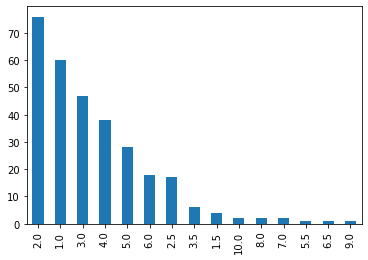

In [ ]:
# checking number of zones
lu_stations['zone'].value_counts().plot(kind='bar')

In [ ]:
print(lu_lines.shape)
lu_lines.info()

(13, 4)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13 entries, 0 to 12
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   line    13 non-null     int64 
 1   name    13 non-null     object
 2   colour  13 non-null     object
 3   stripe  1 non-null      object
dtypes: int64(1), object(3)
memory usage: 544.0+ bytes


In [ ]:
lu_lines

,line,name,colour,stripe
0,1,Bakerloo Line,AE6017,NaN
1,3,Circle Line,FFE02B,NaN
2,6,Hammersmith & City Line,F491A8,NaN
3,7,Jubilee Line,949699,NaN
4,11,Victoria Line,0A9CDA,NaN
5,2,Central Line,F15B2E,NaN
6,4,District Line,00A166,NaN
7,5,East London Line,FBAE34,NaN
8,8,Metropolitan Line,91005A,NaN
9,9,Northern Line,000000,NaN


In [ ]:
lu_conns.head()

,station1,station2,line,time
0,11,163,1,1
1,11,212,1,2
2,49,87,1,1
3,49,197,1,2
4,82,163,1,2


## Stations Map


In [ ]:
"""
"""
london_map = folium.Map(zoom_start=12, width=1200, height=700, location=[51.5072, 0.1076])

for i, r in lu_stations.iterrows():
    #setting for the popup
    popup = folium.Popup(r['name'], max_width=1000)
    #Plotting the Marker for each stationsト
    folium.map.Marker(
        location = [r['latitude'], r['longitude']], 
        popup=popup,
        icon=folium.Icon(color="green", icon="train", prefix='fa')
    ).add_to(london_map)
    
    folium.vector_layers.CircleMarker(
        location=[r['latitude'], r['longitude']], 
        # radius=r['count']/10000,
        color='#3186cc',
        fill_color='#3186cc'
    ).add_to(london_map)

# lets view the london map
london_map

branches


## NetworkX Library

- creating edges and nodes from stations and lines data


First, create an empty MultiGraph which allows for multiple links between two stations

In [ ]:
import networkx as nx
G1 = nx.Graph()



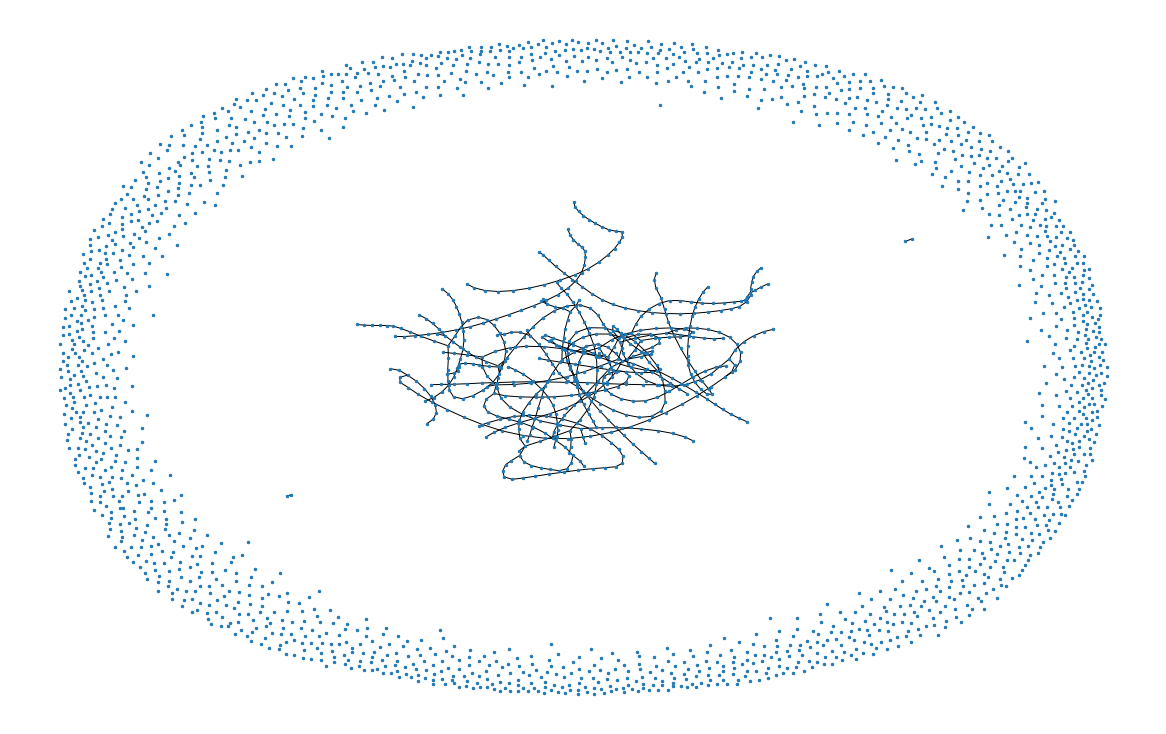

In [ ]:
# adding nodes and edges
G1.add_nodes_from(numbat_nodes_xls['NodeCode'])
G1.add_edges_from(list(zip(lines_mode_links_xls['StartNodeCode'], lines_mode_links_xls['EndNodeCode'])))

plt.figure(figsize=(16, 10))
nx.draw(G1, node_size = 6)

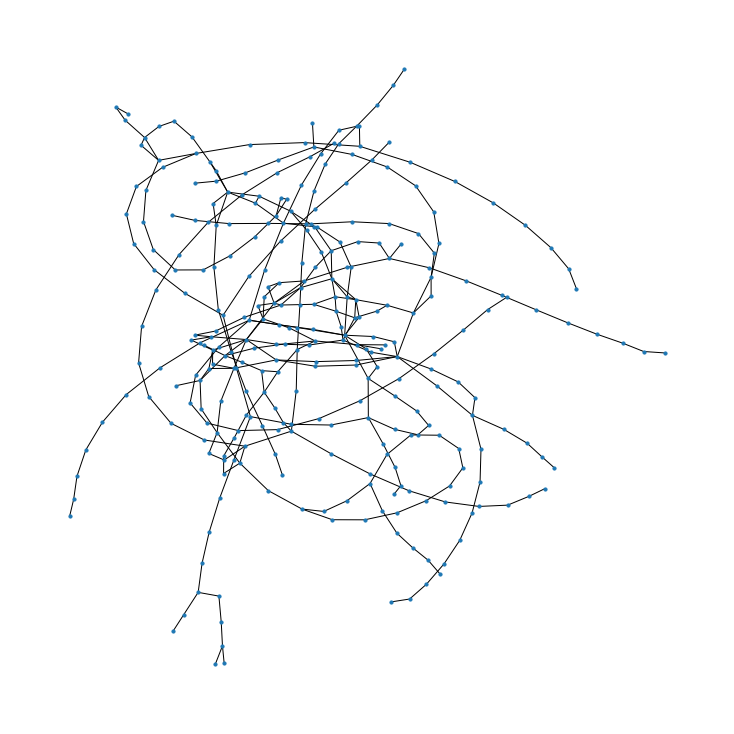

In [ ]:
# using stations data
G = nx.Graph()
G.add_nodes_from(lu_stations['id'])
G.add_edges_from(list(zip(lu_conns['station1'], lu_conns['station2'])))

plt.figure(figsize=(10, 10))
nx.draw(G, node_size=10)

In [ ]:
G2 = nx.MultiGraph()  # trying out a multigraph
G2.add_nodes_from(lu_stations['id'])
G2.add_edges_from(list(zip(lu_conns['station1'], lu_conns['station2'])))


print(nx.info(G2))

MultiGraph with 304 nodes and 409 edges


So for the 304 tube stations we're visualising 409 of the links between them (as there are more links by including outbound routes too).

Let's start with a simplistic plot of the 250miles of tube network:

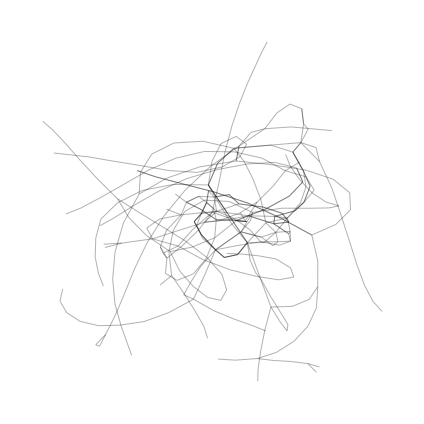

In [ ]:
options = {
    'width': 1,
    'alpha': 0.3,
}

plt.subplots(figsize=(6, 6))
nx.draw_networkx_edges(G2, pos=nx.spring_layout(G), **options)
plt.tight_layout()
plt.axis('off');


Not exactly an icon of British design though we can see which routes serve multiple lines with the darkness of the edges.

Let's change the layout and add some colour

using the coordinates features to define position...


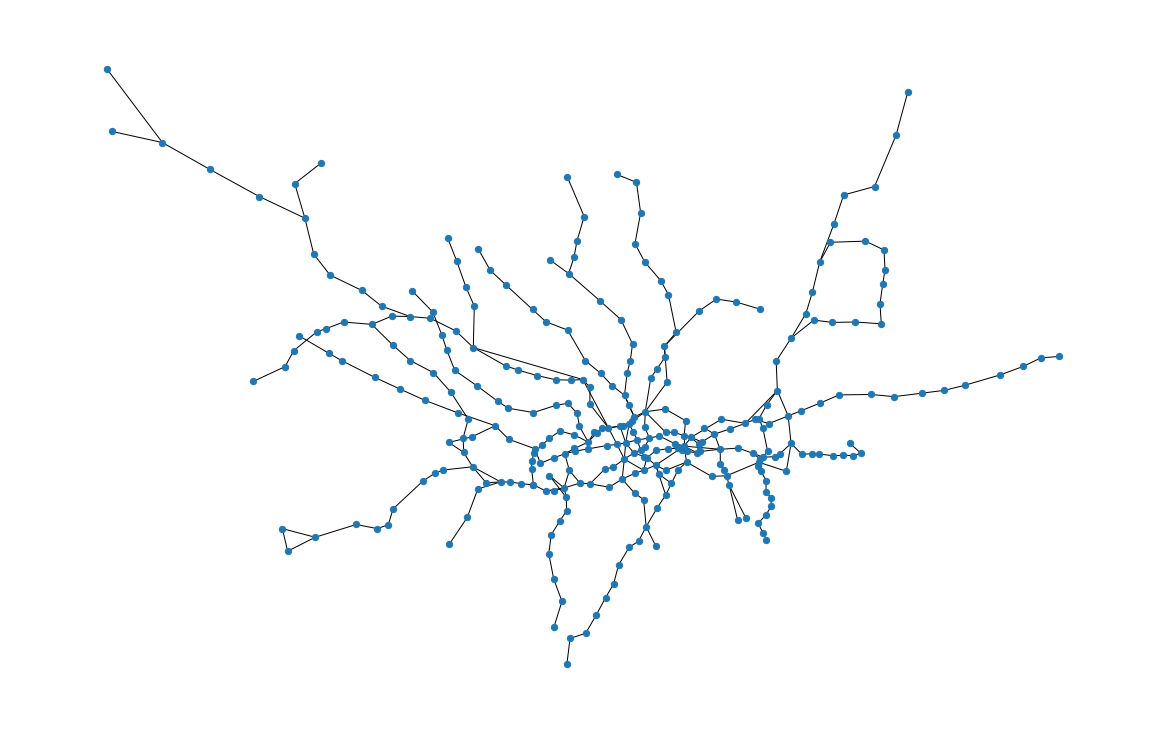

In [ ]:
plt.figure(figsize=(16,10))

cordinates = list(zip(lu_stations['longitude'], lu_stations['latitude']))
positions = dict(zip(lu_stations['id'], cordinates))
nx.draw(G, positions, node_size = 40)

- Labelling the nodes with Station Name details

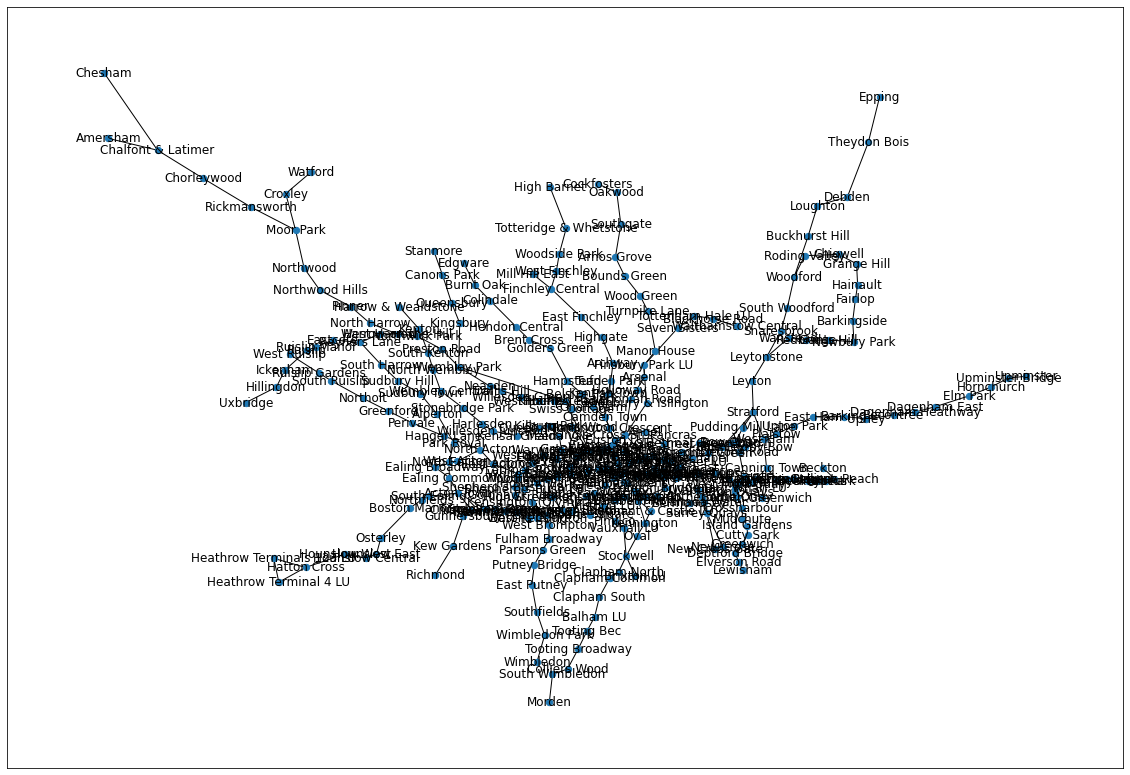

In [ ]:
# relabelling nodes
mapping_dict = dict(zip(lu_stations.id, lu_stations.name))
plt.figure(figsize=(20, 14))

G1 = nx.relabel_nodes(G, mapping_dict)
positions = dict(zip(lu_stations['name'], cordinates))
nx.draw_networkx(G1, positions, node_size = 40)

## Obtaining centrality metrics - Why are centrality measures important?

Centrality measures are a vital tool for understanding networks, often also known as graphs. These algorithms use graph theory to calculate the importance of any given node in a network. They cut through noisy data, revealing parts of the network that need attention – but they all work differently
We can now add a list of our centralities.

we use a lambda function to add station names into a column, based on dictionary and the value of the ID column

we'll use three centrality measures to help us tell which is the most important station in the network.


In [ ]:
dict_names = dict(zip(lu_stations['id'], lu_stations['name']))

centralities = pd.DataFrame()
centralities['ID'] = G.nodes()
centralities['Names'] = centralities["ID"].map(lambda x:dict_names[x])
centralities['degree_centr'] = nx.degree_centrality(G).values()
centralities['closeness_centr'] = nx.closeness_centrality(G).values()
centralities['betweenness_centr'] = nx.betweenness_centrality(G).values()
# centralities['eigenvector_centr'] = nx.eigenvector_centrality(G).values()

obtaining our "Top 10" lists.

In [ ]:
centralities.sort_values(by='closeness_centr', ascending=False).head(10).reset_index()[['Names','closeness_centr']]

,Names,closeness_centr
0,Green Park,0.114210
1,Bond Street,0.111193
2,Westminster,0.110989
3,Oxford Circus,0.109822
4,Waterloo LU,0.109111
5,Baker Street,0.108485
6,Bank and Monument,0.107599
7,Victoria LU,0.106878
8,Hyde Park Corner,0.105796
9,Piccadilly Circus,0.104699


In [ ]:
centralities.sort_values(by='betweenness_centr', ascending=False).head(10).reset_index()[['Names','betweenness_centr']]

,Names,betweenness_centr
0,Green Park,0.354348
1,Bank and Monument,0.338020
2,Waterloo LU,0.335700
3,Baker Street,0.330949
4,Westminster,0.301496
5,Bond Street,0.260138
6,Stratford,0.225590
7,Liverpool Street LU,0.223746
8,Mile End,0.216586
9,Bethnal Green LU,0.211940


In [ ]:
centralities.sort_values(by='betweenness_centr', ascending=True).head(10).reset_index()[['Names','betweenness_centr']]

,Names,betweenness_centr
0,Hammersmith (H&C),0.0
1,West Ruislip,0.0
2,West Kensington,0.0
3,Walthamstow Central,0.0
4,Uxbridge,0.0
5,Chiswick Park,0.0
6,Tower Gateway,0.0
7,Stanmore,0.0
8,Shoreditch,0.0
9,Richmond,0.0


The overwhelming message here is that Green Park is definitely important!

## Generation of centrality visualisations¶
Let's now visualise these values:

1. degree centrality - What does degree centrality tell you?

Degree centrality is one of the easiest to calculate. The degree centrality of a node is simply its degree—the number of edges it has. The higher the degree, the more central the node is. This can be an effective measure, since many nodes with high degrees also have high centrality by other measures.

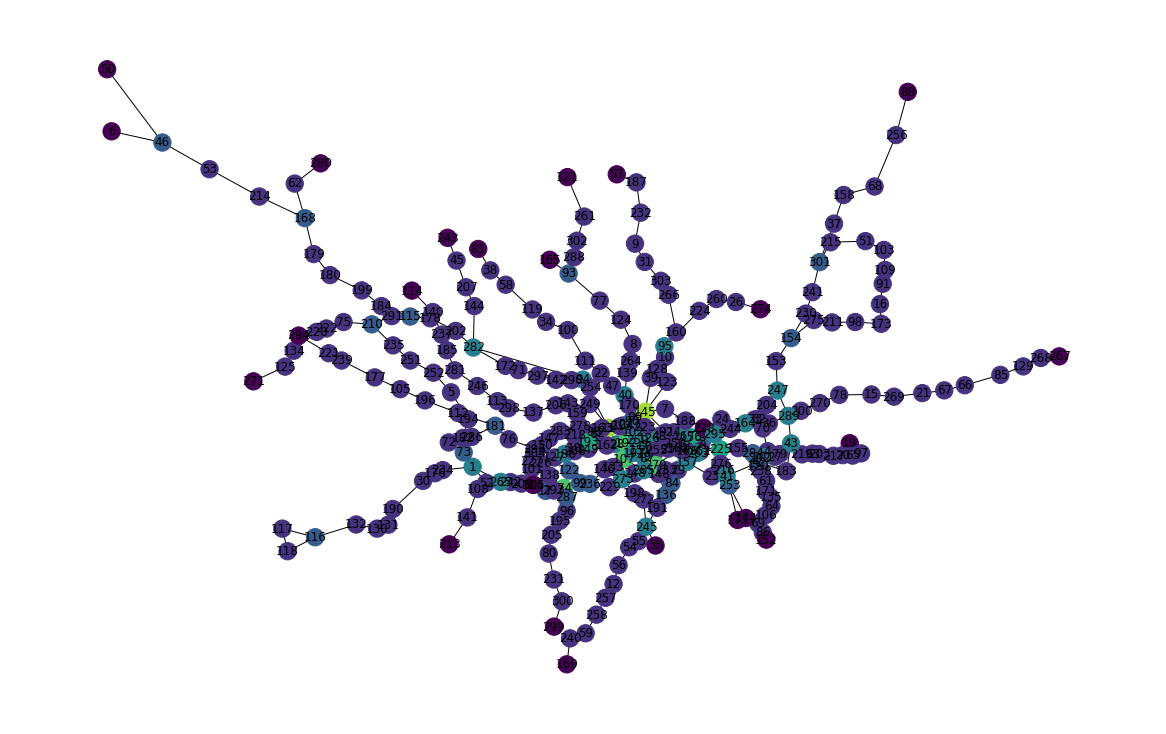

In [ ]:
plt.figure(figsize=(16,10))
coords = list(zip(lu_stations['longitude'], lu_stations['latitude']))
pos = dict(zip(lu_stations['id'], coords))
nx.draw(G, pos, with_labels=True, node_color=list(centralities['degree_centr']))

2. Betweennes centrality - What does betweenness centrality tell you?

Betweenness centrality is a measure that captures a completely different type of importance: the extent to which a certain vertex lies on the shortest paths between other vertices. In other words, it helps identify individuals who play a “bridge spanning” role in a network.

In [ ]:
plt.figure(figsize=(16,10))
coords = list(zip(lu_stations['longitude'], lu_stations['latitude']))
pos = dict(zip(lu_stations['id'], coords))
nx.draw(G, pos, with_labels=True, node_color = list(centralities['betweenness_centr']))

## Using K-Means to obtain zones

At this point we will apply the K-Means algorithm approach in order to split the network into zones.


In [ ]:
from sklearn.cluster import KMeans
import numpy as np

In [ ]:
coord = np.array(list(zip(lu_stations['longitude'], lu_stations['latitude'])))

In [ ]:
model = KMeans(n_clusters=10)
model.fit(coord)
clust_pred = model.predict(coord)

In [ ]:
plot_size   = 20
plot_width  = 10
plot_height = 10

params = {'legend.fontsize': 'large',
          'figure.figsize': (plot_width,plot_height),
          'axes.labelsize': plot_size,
          'axes.titlesize': plot_size,
          'xtick.labelsize': plot_size*0.5,
          'ytick.labelsize': plot_size*0.50,
          'axes.titlepad': 25}
plt.rcParams.update(params)

plt.scatter(coord[:, 0],   
            coord[:, 1],
            c = clust_pred, 
            s=plot_size*2, 
            cmap='Accent')

centers = model.cluster_centers_

plt.scatter(centers[:, 0], 
            centers[:, 1], 
            c = 'red', 
            s=plot_size*10, 
            alpha=0.5);

Next, we are going to use the KElbowVisualizer from the yellowbrick to pick a number of clusters.


In [ ]:
from yellowbrick.cluster import KElbowVisualizer

visualizer = KElbowVisualizer(model, k=(2,12),timings=False)
visualizer.fit(coord)   # Fit the data to the visualizer
visualizer.show()       # Finalize and render the figure

In [ ]:
model = KMeans(n_clusters=5)
model.fit(coord)
clust_pred = model.predict(coord)

plt.scatter(coord[:, 0],   
            coord[:, 1],
            c = clust_pred, 
            s=plot_size*2, 
            cmap='Accent')

centers = model.cluster_centers_

plt.scatter(centers[:, 0], 
            centers[:, 1], 
            c = 'red', 
            s=plot_size*10, 
            alpha=0.5);

These look relalatively sensible upon first sight. Let us now store the cluster memberships into the stations dataframe.

In [ ]:
lu_stations['cluster'] = clust_pred
lu_stations

## Next Step

- integrate stations data with the forecasting data from Data science side
- integrate the networkX based network with bokeh for simulation.